### Setting up Spark

In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)

In [46]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import year, month, dayofmonth

### Data Cleaning 

In [6]:
file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Some house cleaning where the the column names are standardized

for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_time')
df = df.withColumnRenamed('days_for_shipment_(scheduled)', 'predicted_time')
df = df.withColumn("o_year", year(df["order_date"])) \
       .withColumn("o_month", month(df["order_date"])) \
       .withColumn("o_day", dayofmonth(df["order_date"]))

df = df.withColumn("s_year", year(df["shipping_date"])) \
       .withColumn("s_month", month(df["shipping_date"])) \
       .withColumn("s_day", dayofmonth(df["shipping_date"]))

In [7]:
df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)",
             'days_for_shipment_(scheduled)', 'days_for_shipping_(real)')    
df.createOrReplaceTempView("my_table")
df.show(5)

24/07/09 16:40:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

### Setting up right number of products

In [107]:
products_df = spark.sql("""
            Select 
            product_card_id,
            product_name,
            max(product_price) as price,
            max(department_name) as dept_name,
            Max(category_id) as category_id,
            max(category_name) as category,
            sum(sales) as sales,
            sum(order_item_quantity) as quantity
            from my_table
            group by product_card_id, product_name
            order by sales desc
            limit 9""").toPandas()
spark_prod_df = spark.createDataFrame(products_df)
spark_prod_df.createOrReplaceTempView("top_products")
products = products_df['product_card_id']
products

0    1004
1     365
2     957
3     191
4     502
5    1073
6     403
7    1014
8     627
Name: product_card_id, dtype: int32

### Creating prophet predictions

In [50]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def calculate_dates(input_date_str):
    # Parse the input date string to a datetime object
    input_date = datetime.strptime(input_date_str, '%Y-%m-%d')
    
    # Calculate yesterday
    yesterday = input_date - timedelta(days=1)
    
    # Calculate 6 months before the input date
    six_months_before = input_date - relativedelta(months=6)
    
    # Calculate 3 months after the input date
    three_months_after = input_date + relativedelta(months=3)
    
    # Format the dates back to string in 'yyyy-mm-dd' format
    yesterday_str = yesterday.strftime('%Y-%m-%d')
    six_months_before_str = six_months_before.strftime('%Y-%m-%d')
    three_months_after_str = three_months_after.strftime('%Y-%m-%d')
    
    return yesterday_str, six_months_before_str, three_months_after_str

In [61]:
def forecast(id, today_date):
    yesterday, six_months_before, three_months_after = calculate_dates(today_date)
    query_1 = f"""
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = {id}
            AND order_date Between '{six_months_before}' and '{yesterday}'
            group by ds
            order by ds
            """
    
    prophet_df = spark.sql(query_1).toPandas()
    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    prophet.add_country_holidays(country_name='US')
    prophet.fit(prophet_df)
    # Create a DataFrame with future dates for forecasting
    future = prophet.make_future_dataframe(periods=90, freq='D')
    # Generate forecasts
    forecast = prophet.predict(future) 
    query_2 = f"""
            CREATE OR REPLACE TEMPORARY VIEW actual AS
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = {id}
            AND order_date between '{six_months_before}' and '{three_months_after}'
            group by ds
            order by ds
        """
    spark.sql(query_2)
    spark_df = spark.createDataFrame(forecast)
    spark_df.createOrReplaceTempView("predicted")
    spark.sql("""
          CREATE OR REPLACE TEMPORARY VIEW predicted_filter AS
          Select ds, yhat
          from predicted
          """)
    query4 = f"""
            select {id} as product_card_id, p.*, a.y
            from predicted_filter as p
            left join actual as a on a.ds = p.ds
            """
    
    results = spark.sql(query4).toPandas()

    return results

### Predicting for top 9 products

In [62]:
input_date_str = '2016-01-01'

In [75]:
final_df = pd.DataFrame()
for id in products:
    print(id)
    results = forecast(id,input_date_str)    
    final_df = pd.concat([final_df, results], ignore_index=True)

1004


18:09:23 - cmdstanpy - INFO - Chain [1] start processing                        
18:09:23 - cmdstanpy - INFO - Chain [1] done processing


365


18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing


957


18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing


191


18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing


502


18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing


1073


18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing


403


18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing


1014


18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing


627


18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
final_df.to_csv('output/forcasts_top9.csv',index=False)

### Model Errors

In [81]:
sp_df1 = spark.createDataFrame(final_df)
sp_df1.createOrReplaceTempView("results")
spark.sql('select * from results').show(5)

+---------------+-------------------+------------------+---+
|product_card_id|                 ds|              yhat|  y|
+---------------+-------------------+------------------+---+
|           1004|2015-07-01 00:00:00|13.721200222707724| 14|
|           1004|2015-07-02 00:00:00|  17.3299273358424| 16|
|           1004|2015-07-03 00:00:00|18.229191832003217| 19|
|           1004|2015-07-04 00:00:00| 23.32852295667908| 24|
|           1004|2015-07-05 00:00:00|18.789705464215007| 19|
+---------------+-------------------+------------------+---+
only showing top 5 rows



In [85]:
model_errors = spark.sql("""Select
          product_card_id,
          AVG(ABS(y - yhat)) AS MAE,
          AVG((y - yhat) * (y - yhat)) AS MSE,
          SQRT(AVG((y - yhat) * (y - yhat))) AS RMSE
          FROM results
          group by product_card_id
          """).toPandas()
model_errors.to_csv('output/errors.csv',index=False)
model_errors

,product_card_id,MAE,MSE,RMSE
0,365,14.095053,320.566946,17.904383
1,1004,4.955578,48.015767,6.929341
2,957,3.813141,26.587747,5.156331
3,191,8.882334,124.897990,11.175777
4,502,15.074795,378.972673,19.467220
5,1073,3.313212,17.985548,4.240937
6,403,5.937478,79.500160,8.916286
7,1014,13.388804,265.610508,16.297561
8,627,8.553378,117.635385,10.845985


### Visualization to Validate our model

In [100]:
prod_id = 502

In [101]:
results = final_df[final_df['product_card_id'] == prod_id]
results.head(5)

,product_card_id,ds,yhat,y
1096,502,2015-07-01,77.603244,71
1097,502,2015-07-02,72.474593,90
1098,502,2015-07-03,64.488889,63
1099,502,2015-07-04,53.824124,52
1100,502,2015-07-05,64.715570,66


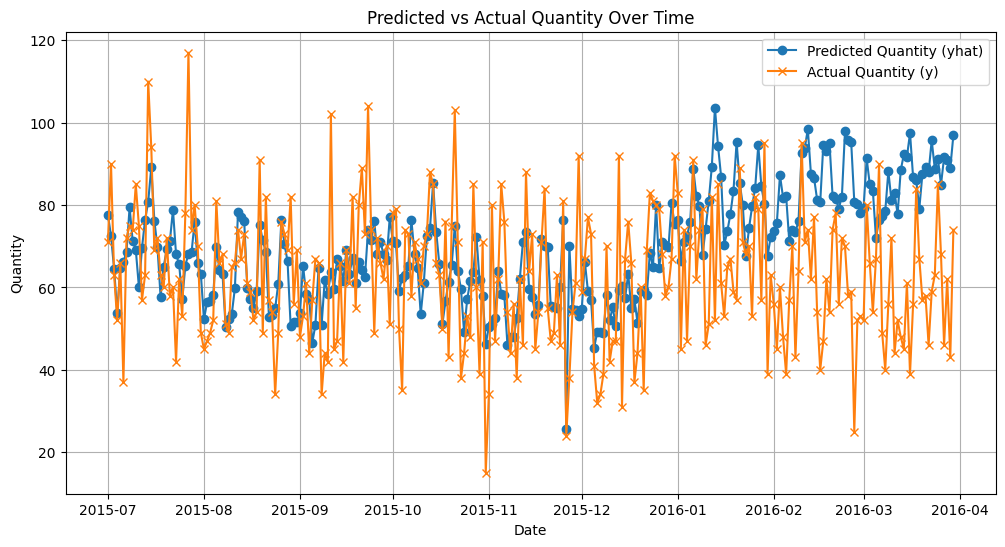

In [102]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(results['ds'], results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

### Obtaining Discounts

In [111]:
spark.sql('select * from my_table').show(5)

+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

In [124]:
discount = spark.sql("""
          Select 
          product_card_id, order_date,
          max(product_price) as price,
          round(avg(order_item_discount_rate),4) as discount_rate,
          round(discount_rate*price,2) as savings
          From my_table
          where product_card_id IN (select product_card_id from top_products)
          and order_date between '2015-07-01' and '2016-04-01'
          group by product_card_id, order_date
          order by product_card_id asc, order_date asc
          """).toPandas()

In [126]:
discount.to_csv('output/discount.csv', index=False)
discount

,product_card_id,order_date,price,discount_rate,savings
0,191,2015-07-01,99.989998,0.0867,8.67
1,191,2015-07-02,99.989998,0.1300,13.00
2,191,2015-07-03,99.989998,0.1315,13.15
3,191,2015-07-04,99.989998,0.1373,13.73
4,191,2015-07-05,99.989998,0.0960,9.60
...,...,...,...,...,...
2479,1073,2016-03-28,199.990005,0.0900,18.00
2480,1073,2016-03-29,199.990005,0.0971,19.42
2481,1073,2016-03-30,199.990005,0.1100,22.00
2482,1073,2016-03-31,199.990005,0.0900,18.00
